# [**Support des caractéristiques catégorielles dans l'amplification de gradient**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_11_ensembles/plot_gradient_boosting_categorical.ipynb)<br/>([_Categorical Feature Support in Gradient Boosting_](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html))

Dans cet exemple, nous comparerons les temps d'entraînement et les performances de prédiction du [**`HistGradientBoostingRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) avec différentes stratégies d'encodage pour les caractéristiques catégorielles. En particulier, nous évaluerons :

- exclure les caractéristiques catégorielles
- utiliser un [**`OneHotEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)
- utiliser un [**`OrdinalEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) et traiter les catégories comme des quantités ordonnées et équidistantes
- utiliser un [**`OrdinalEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) et s'appuyer sur le [**support natif des catégories** (1.11.1.1.4)](https://scikit-learn.org/stable/modules/ensemble.html#categorical-support-gbdt) de l'estimateur [**`HistGradientBoostingRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor).

Nous travaillerons avec le jeu de données sur les maisons d'Ames Lowa, qui se compose de caractéristiques numériques et catégorielles, où le prix de vente des maisons est la variable cible.

# Charger le jeu de données sur les maisons d'Ames

Tout d'abord, nous chargeons les données sur les maisons d'Ames sous forme d'un dataframe pandas. Les caractéristiques sont soit catégoriques soit numériques :

In [1]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(data_id=42165, as_frame=True, return_X_y=True, parser="pandas")

# Select only a subset of features of X to make the example faster to run
categorical_columns_subset = [
    "BldgType",
    "GarageFinish",
    "LotConfig",
    "Functional",
    "MasVnrType",
    "HouseStyle",
    "FireplaceQu",
    "ExterCond",
    "ExterQual",
    "PoolQC",
]

numerical_columns_subset = [
    "3SsnPorch",
    "Fireplaces",
    "BsmtHalfBath",
    "HalfBath",
    "GarageCars",
    "TotRmsAbvGrd",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "GrLivArea",
    "ScreenPorch",
]

X = X[categorical_columns_subset + numerical_columns_subset]
X[categorical_columns_subset] = X[categorical_columns_subset].astype("category")

categorical_columns = X.select_dtypes(include="category").columns
n_categorical_features = len(categorical_columns)
n_numerical_features = X.select_dtypes(include="number").shape[1]

print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

Number of samples: 1460
Number of features: 20
Number of categorical features: 10
Number of numerical features: 10


# Estimateur d'amplification de gradient avec des caractéristiques catégorielles supprimées

En tant que référence, nous créons un estimateur duquel les caractéristiques catégorielles sont exclues :

In [2]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline

dropper = make_column_transformer(
    ("drop", make_column_selector(dtype_include="category")), remainder="passthrough"
)
hist_dropped = make_pipeline(dropper, HistGradientBoostingRegressor(random_state=42))

# Estimateur d'amplification de gradient avec encodage one-hot

Ensuite, nous créons un pipeline qui effectuera un encodage one-hot des caractéristiques catégorielles et laissera passer le reste des données numériques :

In [3]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

hist_one_hot = make_pipeline(
    one_hot_encoder, HistGradientBoostingRegressor(random_state=42)
)

# Estimateur d'amplification de gradient avec encodage ordinal

Ensuite, nous créons un pipeline qui traitera les caractéristiques catégorielles comme si elles étaient des quantités ordonnées, c'est-à-dire que les catégories seront encodées comme 0, 1, 2, etc., et traitées comme des caractéristiques continues.

In [4]:
import numpy as np

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
    # Use short feature names to make it easier to specify the categorical
    # variables in the HistGradientBoostingRegressor in the next step
    # of the pipeline.
    verbose_feature_names_out=False,
)

hist_ordinal = make_pipeline(
    ordinal_encoder, HistGradientBoostingRegressor(random_state=42)
)

# Estimateur d'amplification de gradient avec prise en charge native des caractéristiques catégorielles

Nous créons maintenant un estimateur [**`HistGradientBoostingRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) qui gérera nativement les caractéristiques catégorielles. Cet estimateur ne traitera pas les caractéristiques catégorielles comme des quantités ordonnées.

Comme le [**`HistGradientBoostingRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) exige que les valeurs catégorielles soient encodées dans l'intervalle `[0, n_unique_categories - 1]`, nous continuons de nous appuyer sur un [**`OrdinalEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) pour prétraiter les données.

La principale différence entre ce pipeline et le précédent est que dans celui-ci, nous informons le [**`HistGradientBoostingRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) des caractéristiques catégorielles.

In [5]:
# The ordinal encoder will first output the categorical features, and then the
# continuous (passed-through) features

hist_native = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(
        random_state=42,
        categorical_features=categorical_columns,
    ),
).set_output(transform="pandas")

# Comparaison des modèles

Enfin, nous évaluons les modèles en utilisant la validation croisée. Ici, nous comparons les performances des modèles en termes de [**`mean_absolute_percentage_error`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html#sklearn.metrics.mean_absolute_percentage_error) et temps d'ajustement.

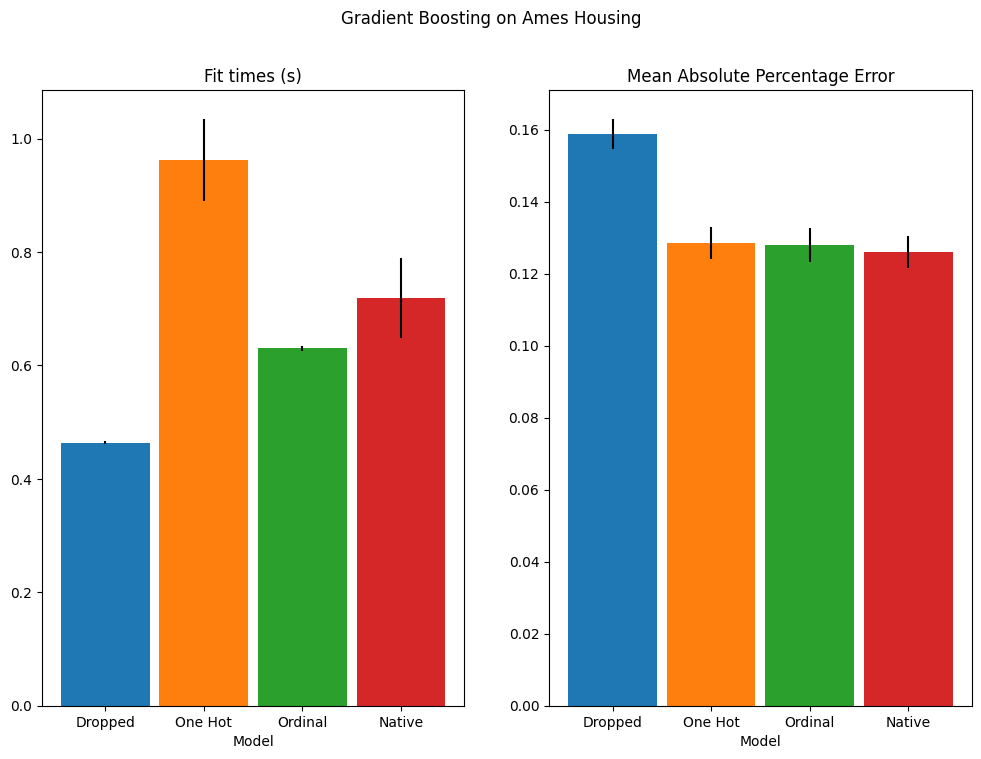

In [6]:
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate

scoring = "neg_mean_absolute_percentage_error"
n_cv_folds = 3

dropped_result = cross_validate(hist_dropped, X, y, cv=n_cv_folds, scoring=scoring)
one_hot_result = cross_validate(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = cross_validate(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
native_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)


def plot_results(figure_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    plot_info = [
        ("fit_time", "Fit times (s)", ax1, None),
        ("test_score", "Mean Absolute Percentage Error", ax2, None),
    ]

    x, width = np.arange(4), 0.9
    for key, title, ax, y_limit in plot_info:
        items = [
            dropped_result[key],
            one_hot_result[key],
            ordinal_result[key],
            native_result[key],
        ]

        mape_cv_mean = [np.mean(np.abs(item)) for item in items]
        mape_cv_std = [np.std(item) for item in items]

        ax.bar(
            x=x,
            height=mape_cv_mean,
            width=width,
            yerr=mape_cv_std,
            color=["C0", "C1", "C2", "C3"],
        )
        ax.set(
            xlabel="Model",
            title=title,
            xticks=x,
            xticklabels=["Dropped", "One Hot", "Ordinal", "Native"],
            ylim=y_limit,
        )
    fig.suptitle(figure_title)


plot_results("Gradient Boosting on Ames Housing")

Nous constatons que le modèle avec des données encodées en "one-hot" est de loin le plus lent. Cela est à prévoir, car l'encodage "one-hot" crée une caractéristique supplémentaire par valeur de catégorie (pour chaque caractéristique catégorielle), ce qui signifie qu'un plus grand nombre de points de division doivent être pris en compte lors de l'ajustement. En théorie, nous nous attendons à ce que la gestion native des caractéristiques catégorielles soit légèrement plus lente que le traitement des catégories comme des quantités ordonnées (« Ordinal »), car la gestion native nécessite de [**trier les catégories** (1.11.1.1.4)](https://scikit-learn.org/stable/modules/ensemble.html#categorical-support-gbdt). Cependant, les temps d'ajustement devraient être proches lorsque le nombre de catégories est faible, et cela ne se reflète pas toujours dans la pratique.

En termes de performances de prédiction, l'omission des caractéristiques catégorielles conduit à de moins bonnes performances. Les trois modèles utilisant des caractéristiques catégorielles présentent des taux d'erreur comparables, avec un léger avantage pour la gestion native.

# Limitation du nombre de divisions

En général, on peut s'attendre à de moins bonnes prédictions à partir de données encodées en "one-hot", en particulier lorsque la profondeur des arbres ou le nombre de nœuds sont limités : avec des données encodées en "one-hot", il faut plus de points de division, c'est-à-dire plus de profondeur, pour obtenir une division équivalente qui pourrait être obtenue en un seul point de division avec une gestion native.

Cela est également vrai lorsque les catégories sont traitées comme des quantités ordonnées : si les catégories sont `A..F` et que la meilleure division est `ACF - BDE`, le modèle "one-hot-encoder" aura besoin de 3 points de division (un par catégorie dans le nœud gauche), et le modèle ordinal non natif aura besoin de 4 divisions : 1 division pour isoler A, 1 division pour isoler `F`, et 2 divisions pour isoler `C` de `BCDE`.

À quel point les performances des modèles diffèrent dans la pratique dépendra du jeu de données et de la flexibilité des arbres.

Pour voir cela, réexaminons la même analyse avec des modèles sous-ajustés où nous limitons artificiellement le nombre total de divisions en limitant à la fois le nombre d'arbres et la profondeur de chaque arbre.

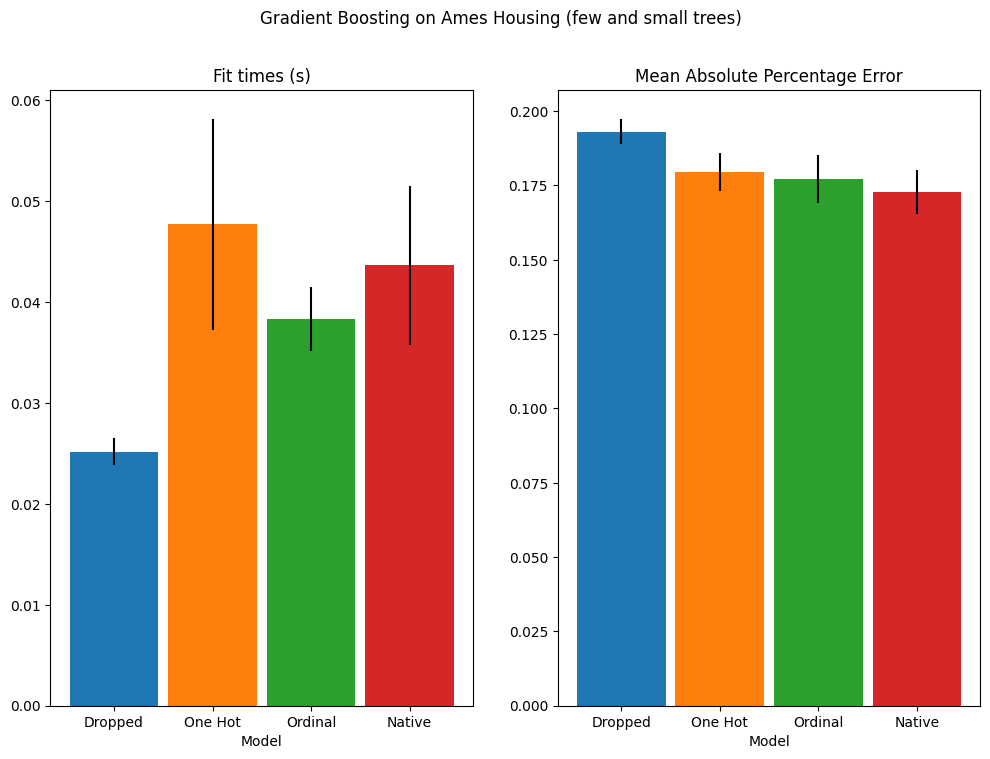

In [7]:
for pipe in (hist_dropped, hist_one_hot, hist_ordinal, hist_native):
    pipe.set_params(
        histgradientboostingregressor__max_depth=3,
        histgradientboostingregressor__max_iter=15,
    )

dropped_result = cross_validate(hist_dropped, X, y, cv=n_cv_folds, scoring=scoring)
one_hot_result = cross_validate(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = cross_validate(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
native_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)

plot_results("Gradient Boosting on Ames Housing (few and small trees)")

plt.show()

Les résultats pour ces modèles de sous-ajustement confirment notre intuition précédente : la stratégie de gestion native des catégories donne les meilleurs résultats lorsque le budget de division est contraint. Les deux autres stratégies (encodage en "one-hot" et traitement des catégories comme des valeurs ordonnées) conduisent à des valeurs d'erreur comparables au modèle de base qui a tout simplement supprimé complètement les caractéristiques catégorielles.